# Data augmentation from a Tensorflow dataset with a Generative Adversarial Networks

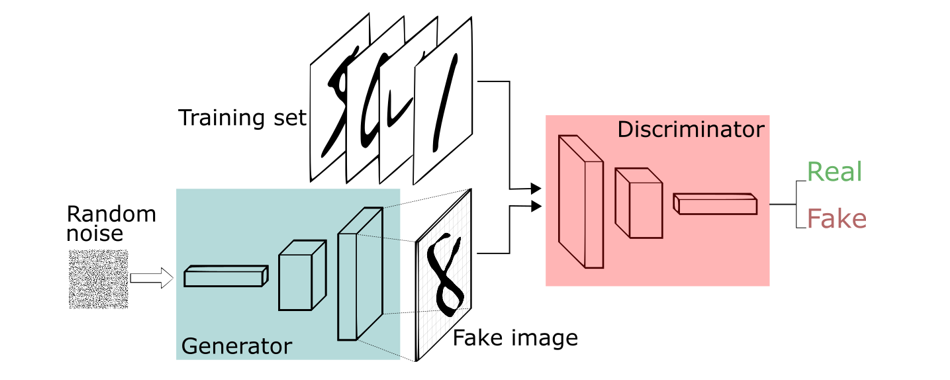

In [1]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [2]:
ds = tfds.load('mnist', split='train')

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
dataiterator = ds.as_numpy_iterator()

dataiterator.next()['image'].shape

(28, 28, 1)

In [4]:
ds.as_numpy_iterator().next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
      

In [5]:
ds.as_numpy_iterator().next()['label']

4

# 2. Visualize Data

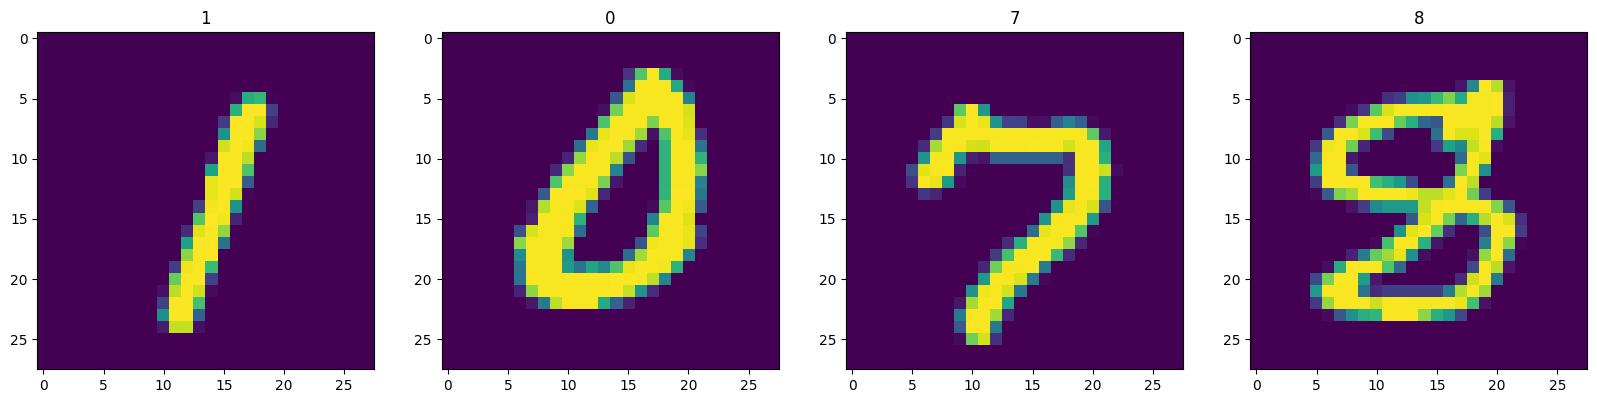

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx in range(4):
    sample = dataiterator.next()
    ax[idx].imshow(sample['image'])
    ax[idx].title.set_text(sample['label'])

# Preprocessing

In [7]:
ds.as_numpy_iterator().next()['image'].max()

255

In [8]:
def scale_images(data):
    image = data['image']
    return image / 255

# Scale the data
ds = ds.map(scale_images)
# Shuffle the data
ds = ds.shuffle(60000)

# Neural Networks

## Generator

In [9]:
def build_generator():
    model = Sequential()

    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [10]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 10s 10s/step


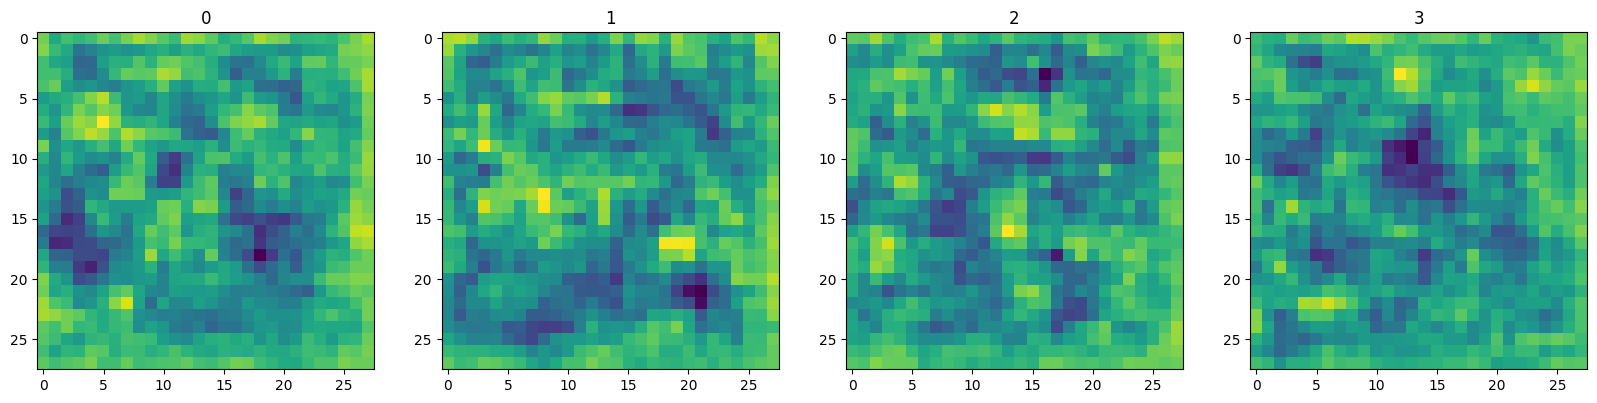

In [11]:
import numpy as np
img = generator.predict(np.random.randn(4,128,1))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img):
    ax[idx].imshow(img)
    ax[idx].title.set_text(idx)

## Discriminator

In [12]:
def build_discriminator():
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid')) # we add a sigmoid for have the value between 0 and 1, 1 for false image and 0 for true image

    return model

In [13]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [14]:
img = generator.predict(np.random.randn(4,128,1))
img.shape

1/1 [==============================] - 0s 26ms/step


(4, 28, 28, 1)

In [15]:
discriminator.predict(img)

1/1 [==============================] - 0s 283ms/step


array([[0.49912658],
       [0.4992765 ],
       [0.499145  ],
       [0.49911803]], dtype=float32)

# 4. Construct Training Loop

In [16]:
# Repeat all these steps until the fake data seems real
for epoch in range(k):
  # Step 1: Train Discriminator on real data for n epochs, keeping freeze the Generator
  for epoch in range(n):
      randomly_select_real_samples
      train_discriminator_on_real_samples
      # Update discriminator's weights based on real data

  # Step 2: Generate fake inputs for generator and train discriminator on fake data
  for epoch in range(n):
      generate_fake_samples
      train_discriminator_on_fake_samples
      # Update discriminator's weights based on fake data

  # Step 3: Train generator with the output of discriminator
  for epoch in range(n):
      generate_fake_samples
      train_generator_based_on_discriminator_feedback
      # Update generator's weights based on discriminator feedback

# End of Training

NameError: ignored

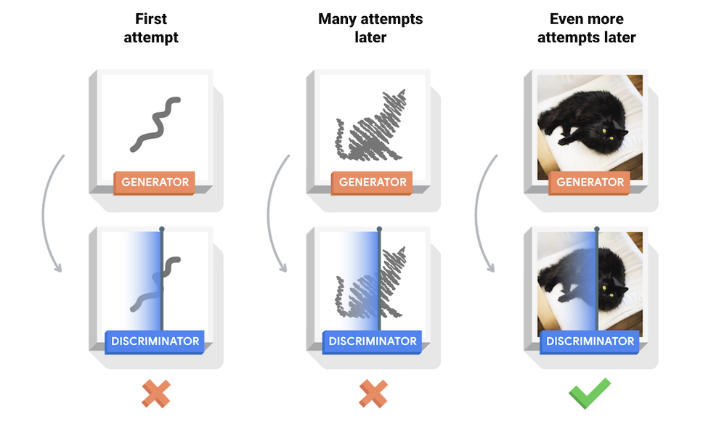

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        with tf.GradientTape() as d_tape:
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
            predicted_labels = self.discriminator(gen_images, training=False)
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

gan = GAN(generator, discriminator)
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [ ]:
ds = ds.batch(128)
hist = gan.fit(ds, epochs=20)

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# Result

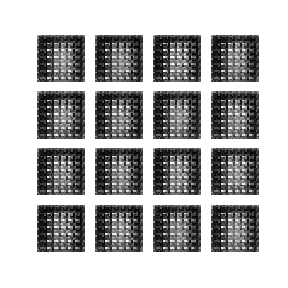

# Result of the generator after 100K epochs

In [17]:
from google.colab import drive
from numpy.random import randn

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [18]:
from keras.models import load_model

model = load_model("/content/gdrive/MyDrive/BDT/generator_model_100K.h5")

1/1 [==============================] - 0s 16ms/step


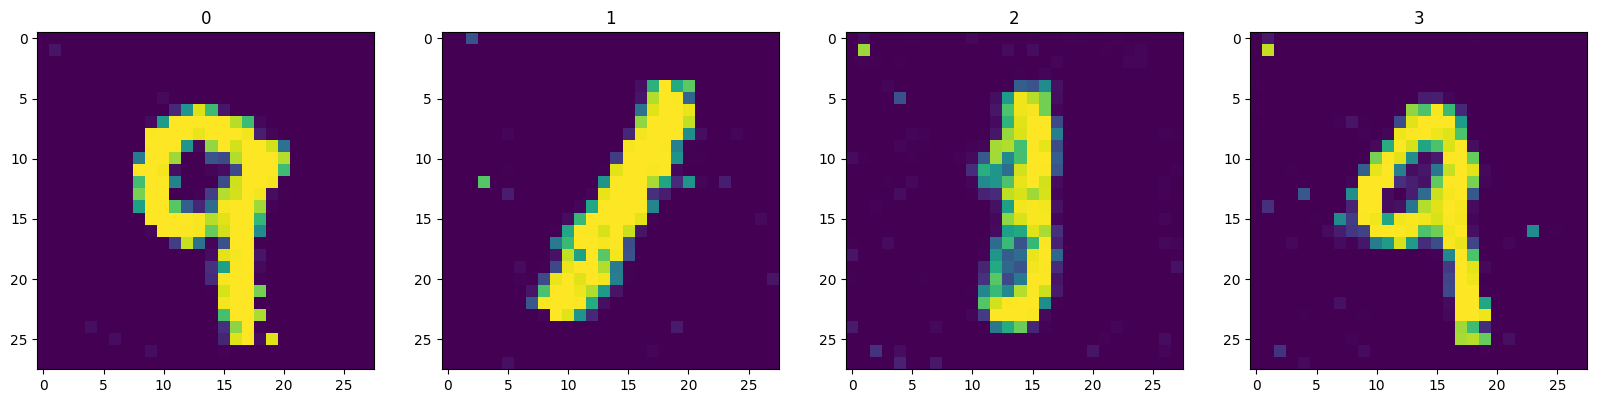

In [20]:
from numpy.random import randn
from matplotlib import pyplot as plt

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4):
    vector = randn(100).reshape(1, 100)
    X = model.predict(vector)

    ax[idx].imshow(X[0, :, :, 0])
    ax[idx].title.set_text(str(idx))

plt.show()